In [3]:
import os
import pickle
import pandas as pd
import json
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Switch to parent path to import local module
parent_path = str(os.getcwd()).split('notebooks')[0] # zeosyn_gen
os.chdir(parent_path)
print('Switched directory to:', os.getcwd())

from eval import get_metric_dataframes, get_prediction_and_ground_truths, eval_single_system
import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
from models.diffusion import *

Switched directory to: /home/jupyter/Elton/Zeolites/zeosyn_gen


In [4]:
# Load diffusion model
model_type = 'diff'
split = 'system'
fname = 'v1'
with open(f'runs/{model_type}/{split}/{fname}/configs.json') as f:
    configs_diff = json.load(f)

# Load CVAE model
model_type = 'cvae'
split = 'system'
fname = 'v9'
with open(f'runs/{model_type}/{split}/{fname}/configs.json') as f:
    configs_cvae = json.load(f)

syn_pred_diff, syn_pred_scaled_diff, syn_true_diff, syn_true_scaled_diff, _ = get_prediction_and_ground_truths(_, configs_diff, cond_scale=1)
syn_pred_cvae, syn_pred_scaled_cvae, syn_true_cvae, syn_true_scaled_cvae, dataset = get_prediction_and_ground_truths(_, configs_cvae)

mmd_zeo_agg_df_diff, wsd_zeo_agg_df_diff, mmd_zeo_osda_df_diff, wsd_zeo_osda_df_diff = get_metric_dataframes(configs_diff)
mmd_zeo_agg_df_cvae, wsd_zeo_agg_df_cvae, mmd_zeo_osda_df_cvae, wsd_zeo_osda_df_cvae = get_metric_dataframes(configs_cvae)

Getting model predictions and grouth truths...
SYSTEMS:
train+val: 1856 test: 464

n_datapoints:
train: 14749 val: 2107 test: 5168
Loading synthetic predictions from saved predictions...
Getting model predictions and grouth truths...
SYSTEMS:
train+val: 1856 test: 464

n_datapoints:
train: 14749 val: 2107 test: 5168
Loading synthetic predictions from saved predictions...


# Metrics in decreasing frequency in test set

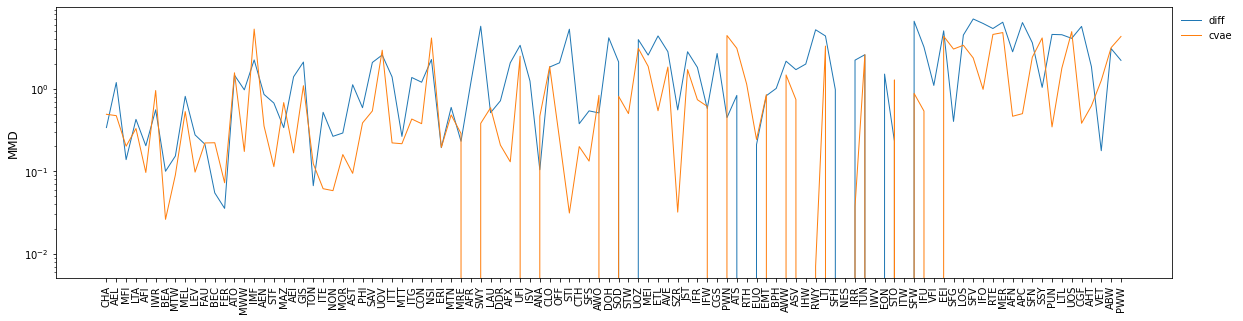

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(mmd_zeo_agg_df_diff['zeo'], mmd_zeo_agg_df_diff['MMD'], label='diff')
plt.plot(mmd_zeo_agg_df_cvae['zeo'], mmd_zeo_agg_df_cvae['MMD'], label='cvae')
plt.ylabel('MMD')
plt.xticks(rotation=90)
plt.yscale('log')
plt.legend()
plt.show()

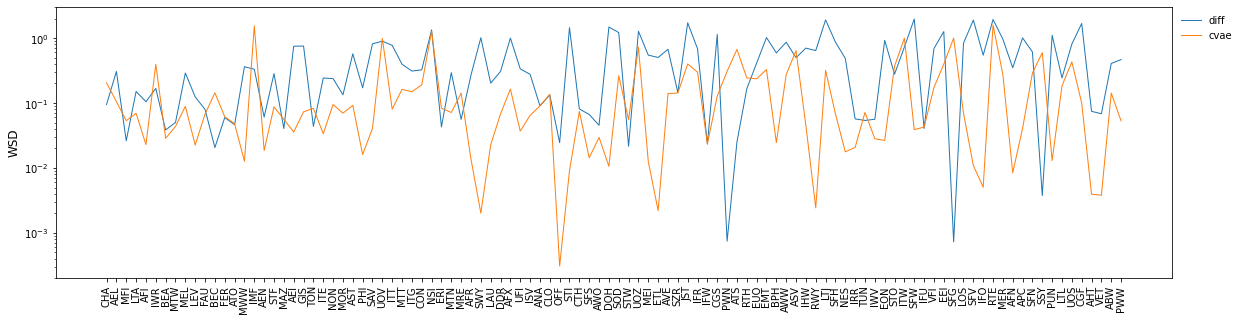

In [6]:
plt.figure(figsize=(20, 5))
plt.plot(wsd_zeo_agg_df_diff['zeo'], wsd_zeo_agg_df_diff['WSD'], label='diff')
plt.plot(wsd_zeo_agg_df_cvae['zeo'], wsd_zeo_agg_df_cvae['WSD'], label='cvae')
plt.ylabel('WSD')
plt.xticks(rotation=90)
plt.yscale('log')
plt.legend()
plt.show()

MMD diff: 0.0547065734863281
WSD diff: 0.0206314043453441

MMD cvae: 0.2216138839721679
WSD cvae: 0.1437506065964757


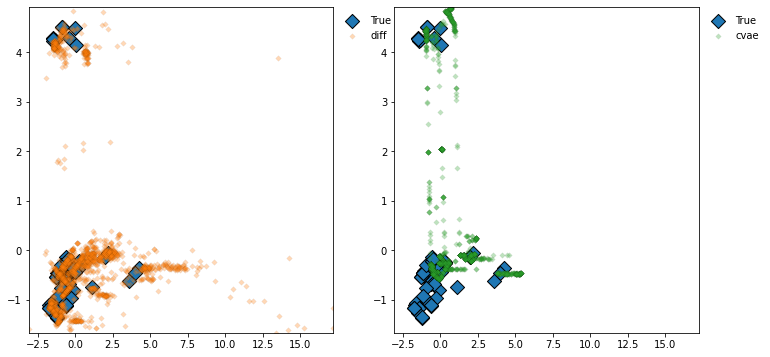

In [12]:
def compare_side_by_side(syn_pred1, syn_pred_scaled1, syn_pred2, syn_pred_scaled2, syn_true, syn_true_scaled, dataset, mmd_zeo_agg_df1, wsd_zeo_agg_df1, mmd_zeo_osda_df1, wsd_zeo_osda_df1, mmd_zeo_agg_df2, wsd_zeo_agg_df2, mmd_zeo_osda_df2, wsd_zeo_osda_df2, zeo, osda=None, plot=True, print_metrics=True, pca=False):
    
    if osda == None: # Zeolite-aggregated
        if plot:
            print(f'====== ZEO: {zeo} ======')

        sys_syn_true = syn_true[syn_true['zeo'] == zeo]
        sys_syn_true_scaled = syn_true_scaled[syn_true_scaled['zeo'] == zeo]

        sys_syn_pred1 = syn_pred1[syn_pred1['zeo'] == zeo]
        sys_syn_pred2 = syn_pred2[syn_pred2['zeo'] == zeo]

        sys_syn_pred_scaled1 = syn_pred_scaled1[syn_pred_scaled1['zeo'] == zeo]
        sys_syn_pred_scaled2 = syn_pred_scaled2[syn_pred_scaled2['zeo'] == zeo]

        if print_metrics:
            mmd1 = mmd_zeo_agg_df1[mmd_zeo_agg_df1['zeo']==zeo]['MMD'].item()
            mmd2 = mmd_zeo_agg_df2[mmd_zeo_agg_df2['zeo']==zeo]['MMD'].item()
            wsd1 = wsd_zeo_agg_df1[wsd_zeo_agg_df1['zeo']==zeo]['WSD'].item()
            wsd2 = wsd_zeo_agg_df2[wsd_zeo_agg_df2['zeo']==zeo]['WSD'].item()

            print('MMD diff:', mmd1)
            print('WSD diff:', wsd1)
            print()
            print('MMD cvae:', mmd2)
            print('WSD cvae:', wsd2)

    else: # Zeolite-OSDA
        if plot:
            print(f'====== ZEO: {zeo} OSDA: {osda} ======')

        sys_syn_true = syn_true[(syn_true['zeo'] == zeo) & (syn_true['osda'] == osda)]
        sys_syn_true_scaled = syn_true_scaled[(syn_true_scaled['zeo'] == zeo) & (syn_true_scaled['osda'] == osda)]

        sys_syn_pred1 = syn_pred1[(syn_pred1['zeo'] == zeo) & (syn_pred1['osda'] == osda)]
        sys_syn_pred2 = syn_pred2[(syn_pred2['zeo'] == zeo) & (syn_pred2['osda'] == osda)]

        sys_syn_pred_scaled1 = syn_pred_scaled1[(syn_pred_scaled1['zeo'] == zeo) & (syn_pred_scaled1['osda'] == osda)]
        sys_syn_pred_scaled2 = syn_pred_scaled2[(syn_pred_scaled2['zeo'] == zeo) & (syn_pred_scaled2['osda'] == osda)]

        if print_metrics:
            mmd1 = mmd_zeo_osda_df1[(mmd_zeo_osda_df1['zeo']==zeo) & (mmd_zeo_osda_df1['osda']==osda)]['MMD'].item()
            mmd2 = mmd_zeo_osda_df2[(mmd_zeo_osda_df2['zeo']==zeo) & (mmd_zeo_osda_df2['osda']==osda)]['MMD'].item()
            wsd1 = wsd_zeo_osda_df1[(wsd_zeo_osda_df1['zeo']==zeo) & (wsd_zeo_osda_df1['osda']==osda)]['WSD'].item()
            wsd2 = wsd_zeo_osda_df2[(wsd_zeo_osda_df2['zeo']==zeo) & (wsd_zeo_osda_df2['osda']==osda)]['WSD'].item()

            print('MMD diff:', mmd1)
            print('WSD diff:', wsd1)
            print()
            print('MMD cvae:', mmd2)
            print('WSD cvae:', wsd2)

    if plot:
        utils.compare_gel_conds([sys_syn_pred1, sys_syn_pred2, sys_syn_true], ['diff', 'cvae', 'True'], [True, True, False], [False, False, True], ['tab:orange', 'tab:green', 'tab:blue'], common_norm=True, alpha=0.35)
    
    if pca:
        combined_df = pd.concat([sys_syn_pred1, sys_syn_pred2, sys_syn_true])
        combined_df['origin'] = ['diff']*len(sys_syn_pred1) + ['cvae']*len(sys_syn_pred2) + ['True']*len(sys_syn_true)
        X = combined_df[dataset.ratio_names+dataset.cond_names].values
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        X_pca = pd.DataFrame({'PC1': X_pca[:, 0], 'PC2': X_pca[:, 1], 'origin': combined_df['origin']})
        
        sys_syn_pred_pca1 = X_pca[X_pca['origin'] == 'diff']
        sys_syn_pred_pca2 = X_pca[X_pca['origin'] == 'cvae']
        sys_syn_true_pca = X_pca[X_pca['origin'] == 'True']

        fig = plt.figure(figsize=(12, 6))

        ax1 = fig.add_subplot(1, 2, 1)
        ax1.scatter(sys_syn_true_pca['PC1'], sys_syn_true_pca['PC2'], label='True', color='tab:blue', alpha=1, s=100, linewidth=1, edgecolor='black')
        ax1.scatter(sys_syn_pred_pca1['PC1'], sys_syn_pred_pca1['PC2'], label='diff', color='tab:orange', alpha=0.3, linewidth=0.1, edgecolor='black')
        ax1.legend()
        ax1.set_xlim(X_pca['PC1'].min(), X_pca['PC1'].max())
        ax1.set_ylim(X_pca['PC2'].min(), X_pca['PC2'].max())
    
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.scatter(sys_syn_true_pca['PC1'], sys_syn_true_pca['PC2'], label='True', color='tab:blue', alpha=1, s=100, linewidth=1, edgecolor='black')
        ax2.scatter(sys_syn_pred_pca2['PC1'], sys_syn_pred_pca2['PC2'], label='cvae', color='tab:green', alpha=0.3, linewidth=0.1, edgecolor='black')
        ax2.legend()
        ax2.set_xlim(X_pca['PC1'].min(), X_pca['PC1'].max())
        ax2.set_ylim(X_pca['PC2'].min(), X_pca['PC2'].max())
        
        plt.show()

    print()
    
compare_side_by_side(syn_pred_diff, syn_pred_scaled_diff, syn_pred_cvae, syn_pred_scaled_cvae, syn_true_diff, syn_true_scaled_diff, dataset, mmd_zeo_agg_df_diff, wsd_zeo_agg_df_diff, mmd_zeo_osda_df_diff, wsd_zeo_osda_df_diff, mmd_zeo_agg_df_cvae, wsd_zeo_agg_df_cvae, mmd_zeo_osda_df_cvae, wsd_zeo_osda_df_cvae, zeo='BEC', plot=False, pca=True)
                    # (syn_pred_cvae, syn_pred_scaled_cvae, syn_pred_diff, syn_pred_scaled_diff, syn_true_cvae, syn_true_scaled_cvae, dataset, mmd_zeo_agg_df_cvae, wsd_zeo_agg_df_cvae, mmd_zeo_osda_df_cvae, wsd_zeo_osda_df_cvae, mmd_zeo_agg_df_diff, wsd_zeo_agg_df_diff, mmd_zeo_osda_df_diff, wsd_zeo_osda_df_diff, zeo='BEC', plot=False, pca=True)

# Zeolite-aggregated

MMD diff: 0.3386220932006836
WSD diff: 0.0948450222222337

MMD cvae: 0.4902276992797851
WSD cvae: 0.2049860147530744


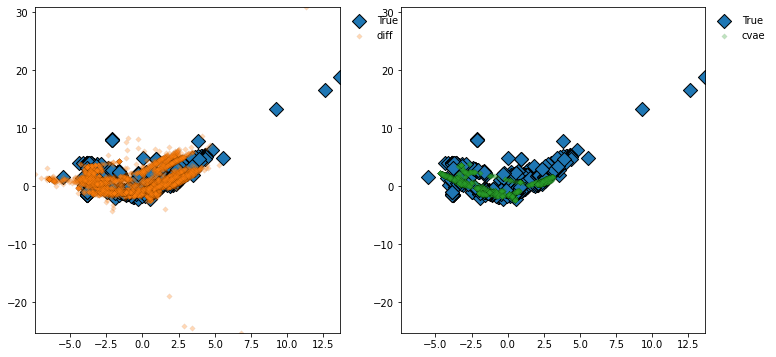


MMD diff: 1.188796043395996
WSD diff: 0.3064060400983838

MMD cvae: 0.4718341827392578
WSD cvae: 0.1051624182522638


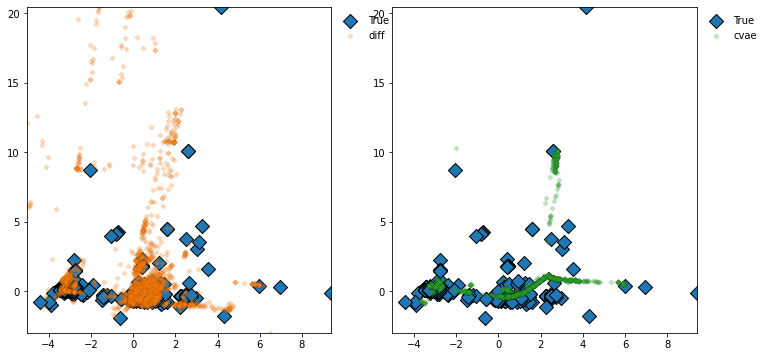


MMD diff: 0.1384210586547851
WSD diff: 0.0262517423335006

MMD cvae: 0.2011032104492187
WSD cvae: 0.0534990278483909


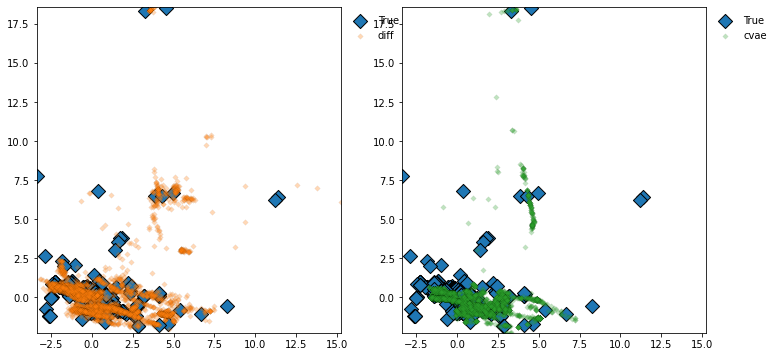


MMD diff: 0.425656795501709
WSD diff: 0.1507018267490754

MMD cvae: 0.3295369148254394
WSD cvae: 0.0695925032499771


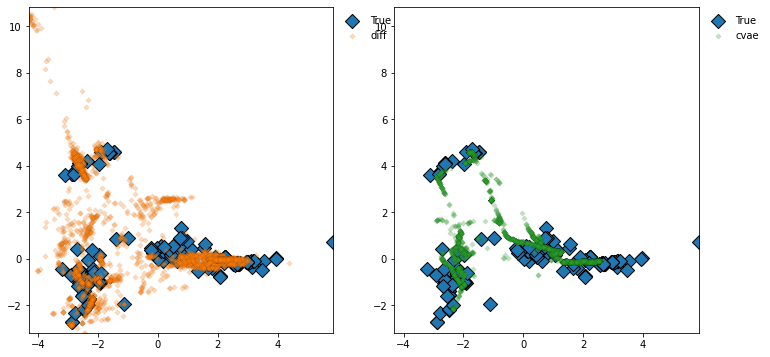


MMD diff: 0.2037591934204101
WSD diff: 0.1047167842818172

MMD cvae: 0.0966787338256836
WSD cvae: 0.0229179035772445


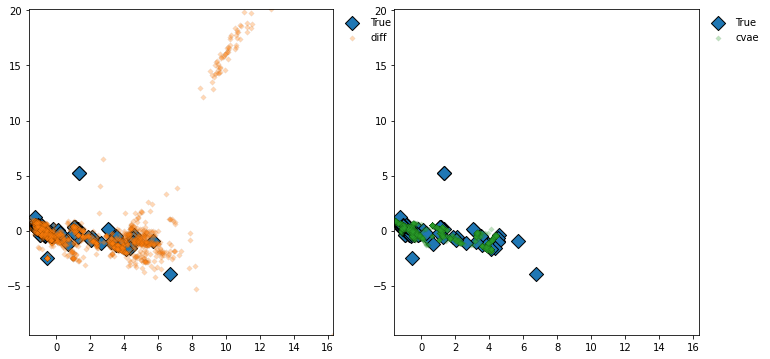


MMD diff: 0.5554304122924805
WSD diff: 0.1680020513633895

MMD cvae: 0.95143461227417
WSD cvae: 0.394469225964524


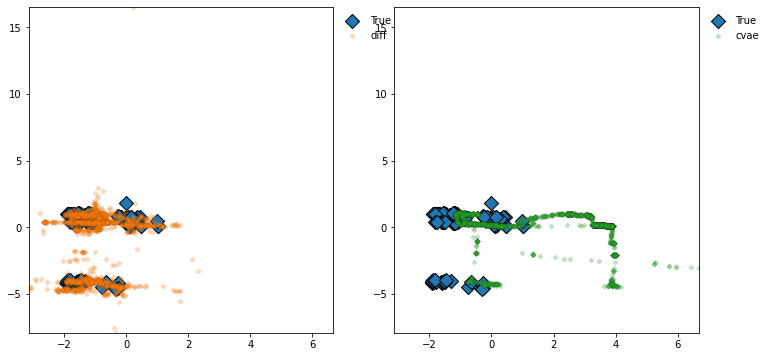


MMD diff: 0.0999689102172851
WSD diff: 0.0384746553194661

MMD cvae: 0.0261478424072265
WSD cvae: 0.0286029394857993


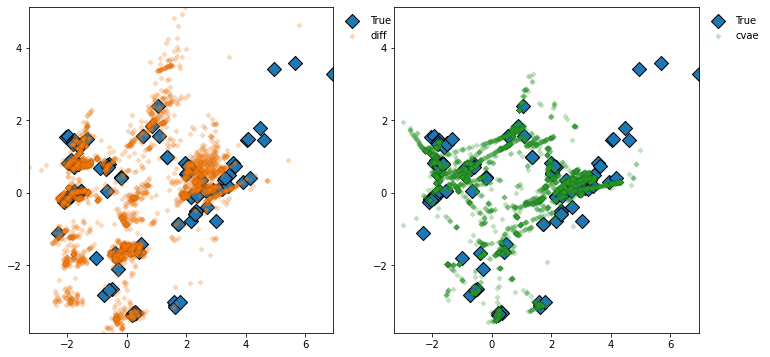


MMD diff: 0.1530132293701172
WSD diff: 0.0502424680003665

MMD cvae: 0.0903272628784179
WSD cvae: 0.043661300323506


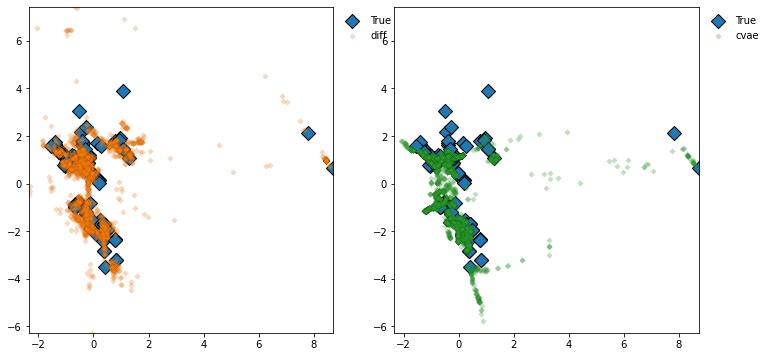


MMD diff: 0.808929443359375
WSD diff: 0.2901406314117103

MMD cvae: 0.5282268524169922
WSD cvae: 0.0890261904789735


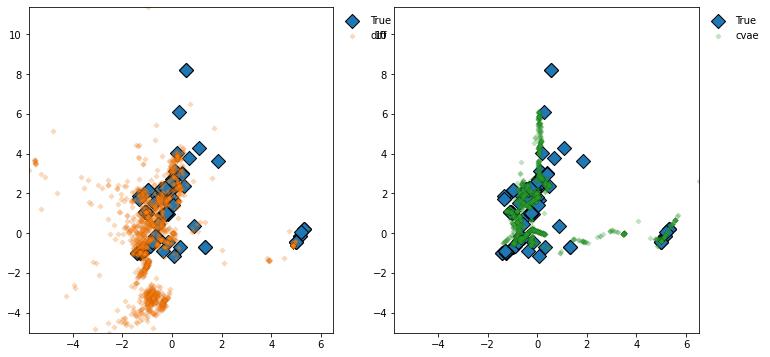


MMD diff: 0.2758436203002929
WSD diff: 0.1241990322839714

MMD cvae: 0.0976495742797851
WSD cvae: 0.0225714643870337


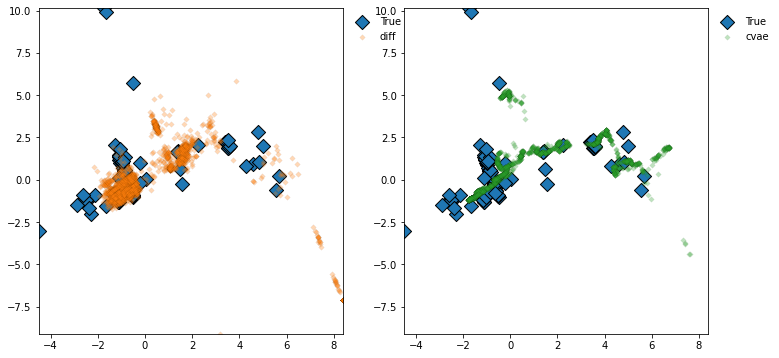


MMD diff: 0.212590217590332
WSD diff: 0.0797363697263029

MMD cvae: 0.2202520370483398
WSD cvae: 0.0676640282236158


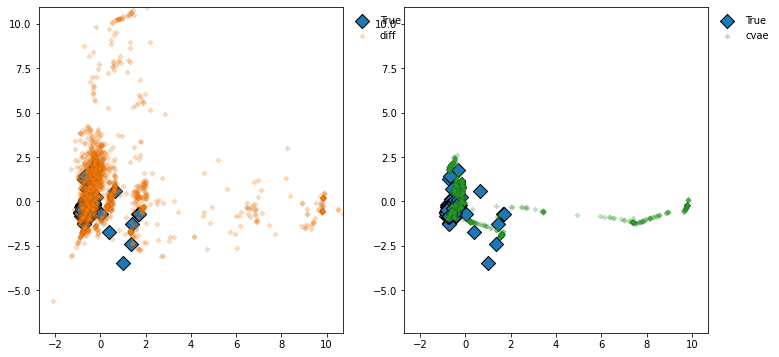


MMD diff: 0.0547065734863281
WSD diff: 0.0206314043453441

MMD cvae: 0.2216138839721679
WSD cvae: 0.1437506065964757


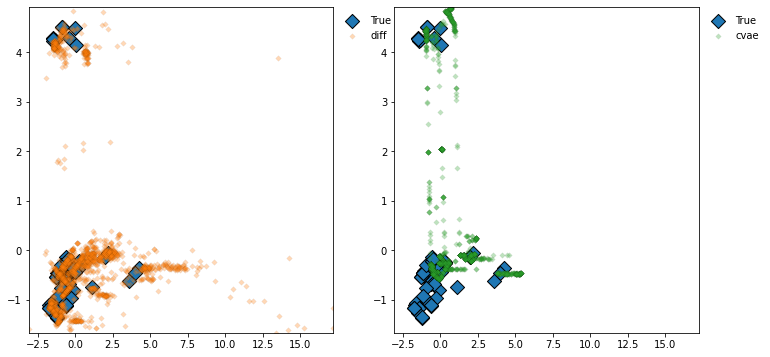


MMD diff: 0.0354871749877929
WSD diff: 0.0597540936459428

MMD cvae: 0.0725412368774414
WSD cvae: 0.0615496281583757


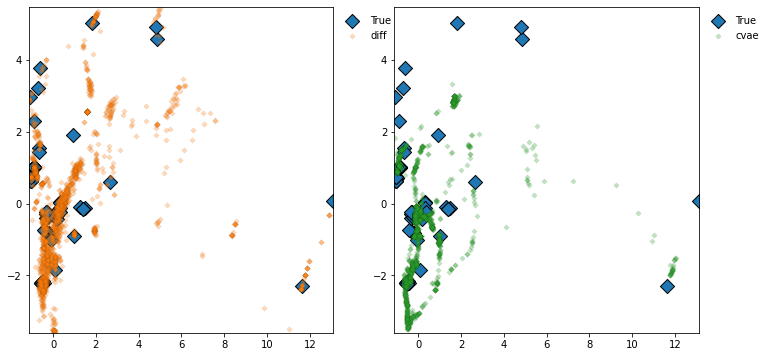


MMD diff: 1.4608898162841797
WSD diff: 0.046346637228182

MMD cvae: 1.560288429260254
WSD cvae: 0.0481283307112068


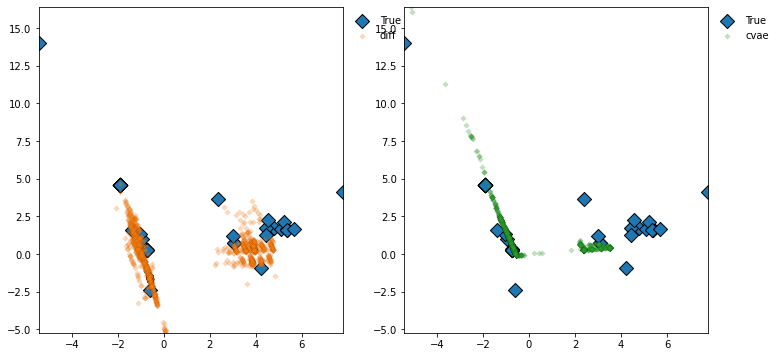


MMD diff: 0.969670295715332
WSD diff: 0.3622483767746963

MMD cvae: 0.1737470626831054
WSD cvae: 0.0126796389329543


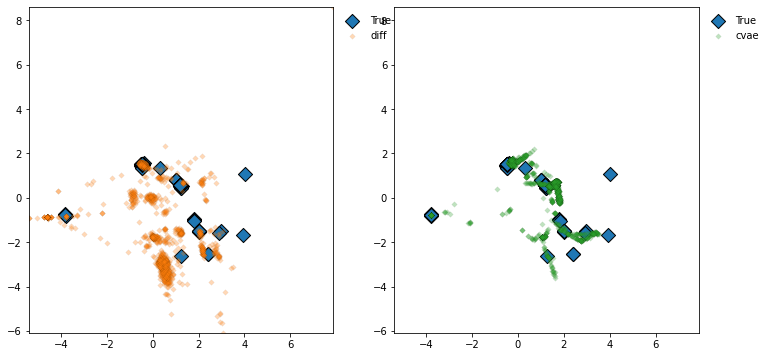


MMD diff: 2.234683990478516
WSD diff: 0.3312211607808673

MMD cvae: 5.277106285095215
WSD cvae: 1.5429847711671938


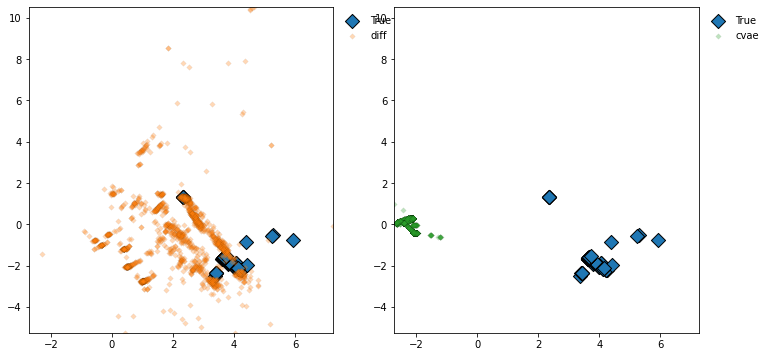


MMD diff: 0.8535709381103516
WSD diff: 0.0608295995885365

MMD cvae: 0.3535900115966797
WSD cvae: 0.0185492837825918


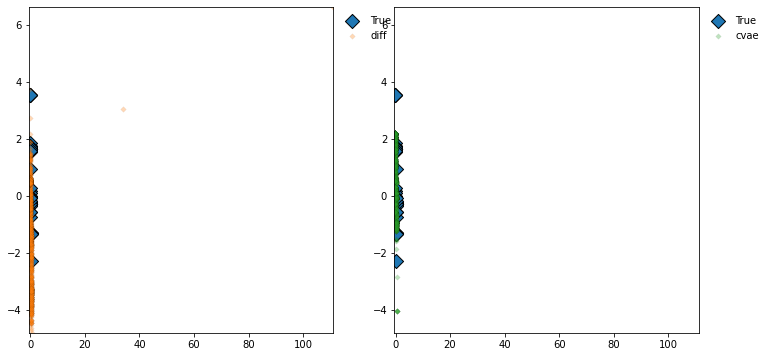


MMD diff: 0.6705808639526367
WSD diff: 0.2836973601503715

MMD cvae: 0.1137104034423828
WSD cvae: 0.0873348709970073


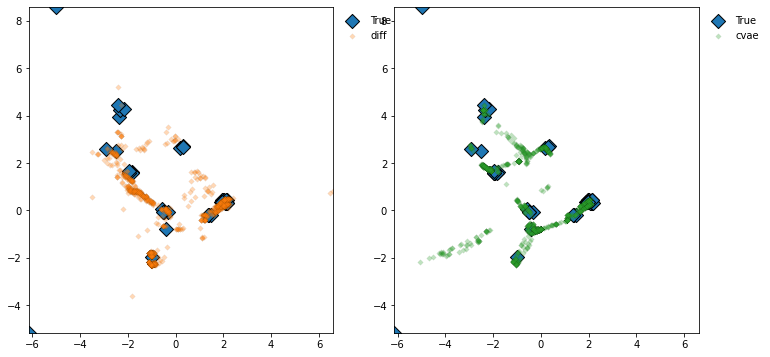


MMD diff: 0.3373527526855469
WSD diff: 0.0404902207664939

MMD cvae: 0.6793203353881836
WSD cvae: 0.0561751580525872


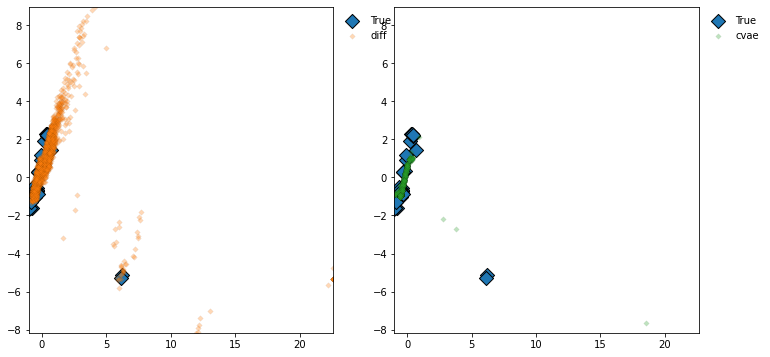


MMD diff: 1.394160270690918
WSD diff: 0.7491448224383079

MMD cvae: 0.1669569015502929
WSD cvae: 0.0358328828256673


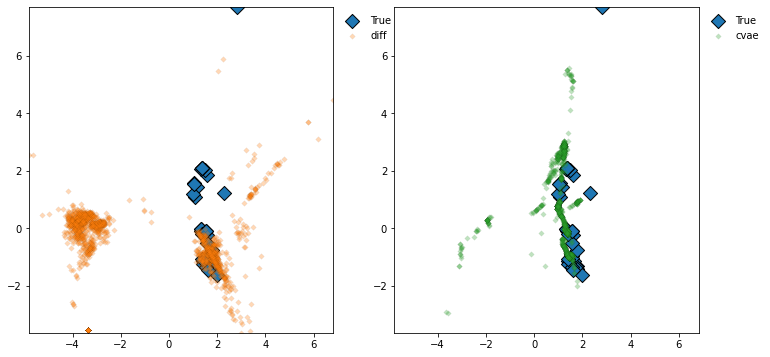


MMD diff: 2.106164932250977
WSD diff: 0.7541967310666753

MMD cvae: 1.0880584716796875
WSD cvae: 0.0731858463150887


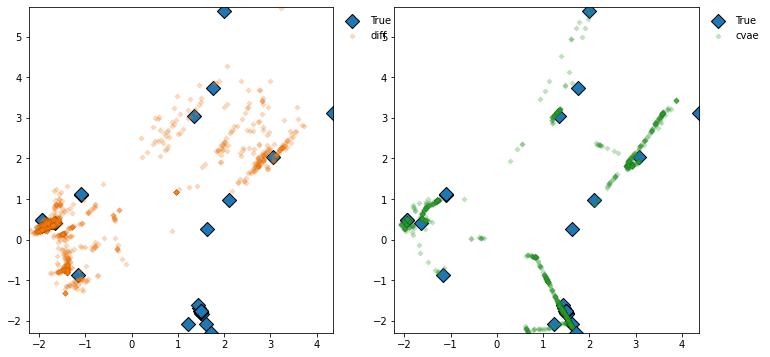


MMD diff: 0.0668563842773437
WSD diff: 0.0436738929881607

MMD cvae: 0.1234779357910156
WSD cvae: 0.0828242548206612


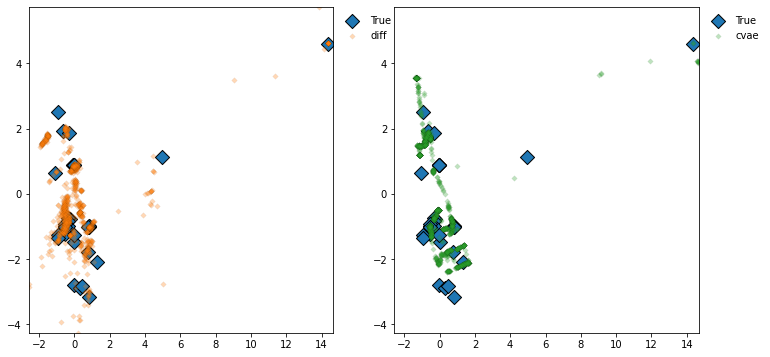


MMD diff: 0.518061637878418
WSD diff: 0.2425908110509224

MMD cvae: 0.0614633560180664
WSD cvae: 0.0337636808110509


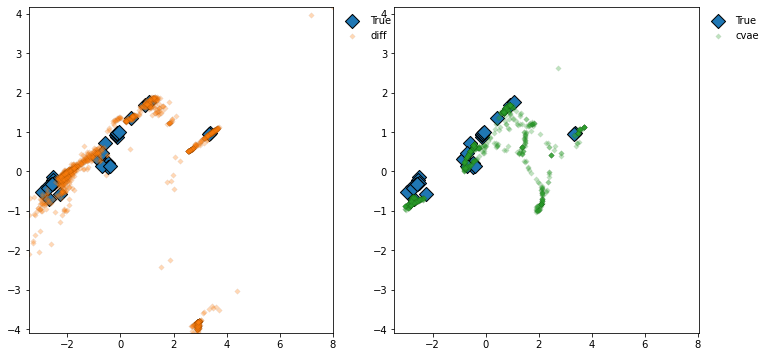


MMD diff: 0.2650480270385742
WSD diff: 0.2377796404477067

MMD cvae: 0.0582227706909179
WSD cvae: 0.0948039021746401


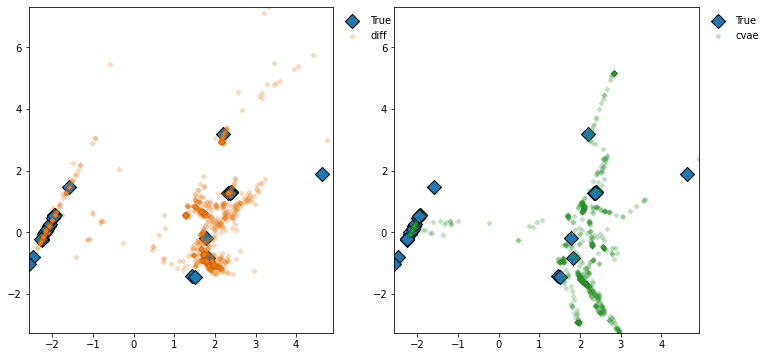


MMD diff: 0.2909393310546875
WSD diff: 0.1337254910235215

MMD cvae: 0.1594648361206054
WSD cvae: 0.0698496017044075


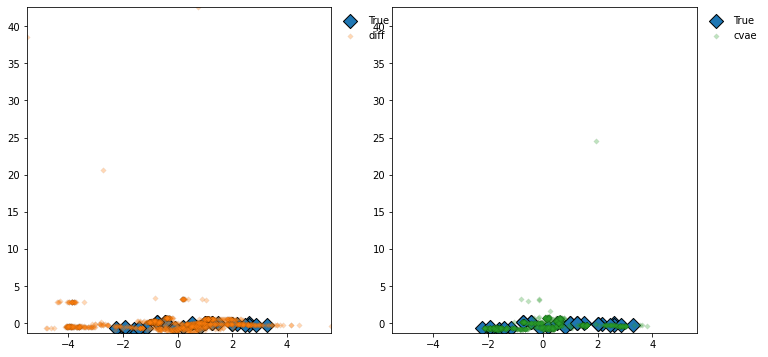


MMD diff: 1.1193222999572754
WSD diff: 0.5725905973799938

MMD cvae: 0.0943641662597656
WSD cvae: 0.092231143918779


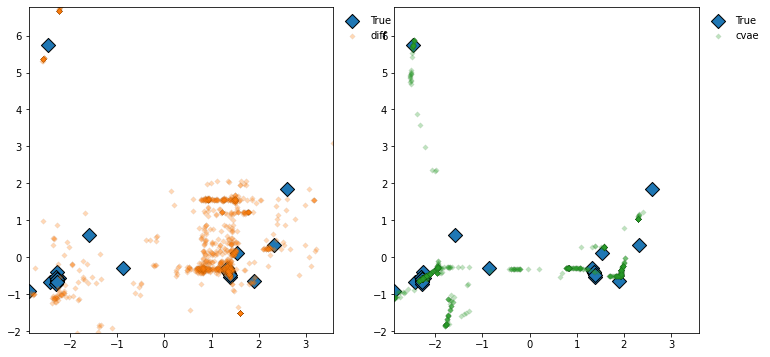


MMD diff: 0.588505744934082
WSD diff: 0.1715367714057494

MMD cvae: 0.3846969604492187
WSD cvae: 0.0160910106576439


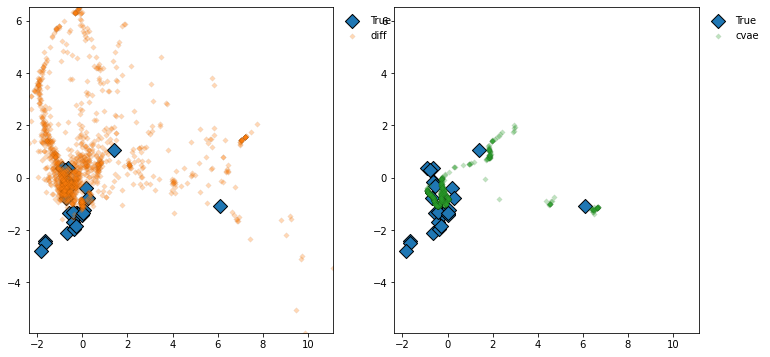


MMD diff: 2.0817151069641118
WSD diff: 0.8163403884128347

MMD cvae: 0.5379724502563477
WSD cvae: 0.0406647382979758


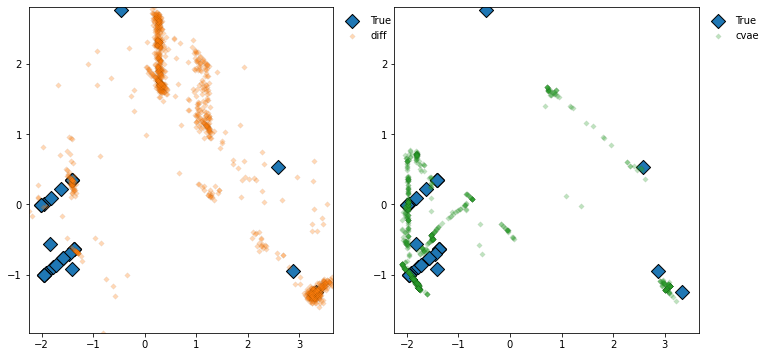


MMD diff: 2.563845634460449
WSD diff: 0.8945527826540395

MMD cvae: 2.9304637908935547
WSD cvae: 0.986976931562558


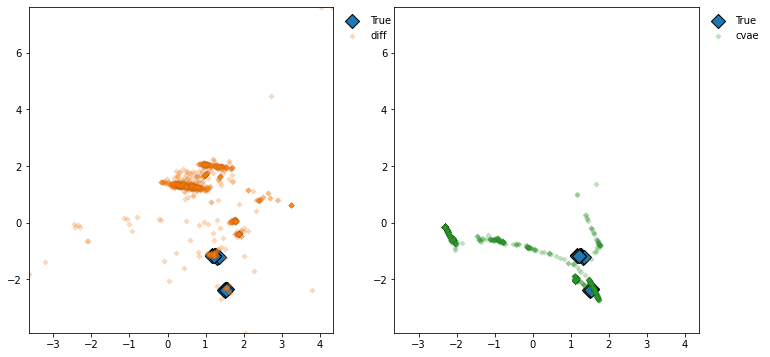


MMD diff: 1.390134334564209
WSD diff: 0.7727469369054745

MMD cvae: 0.2206287384033203
WSD cvae: 0.0803555909477306


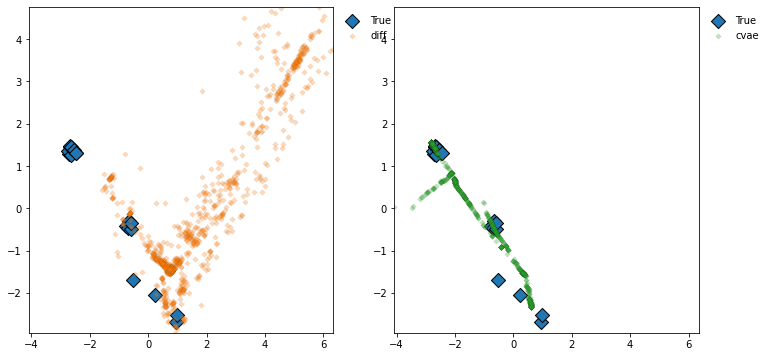

In [13]:
count = 0
for zeo in mmd_zeo_agg_df_cvae['zeo']:
    try:
        compare_side_by_side(syn_pred_diff, syn_pred_scaled_diff, syn_pred_cvae, syn_pred_scaled_cvae, syn_true_diff, syn_true_scaled_diff, dataset, mmd_zeo_agg_df_diff, wsd_zeo_agg_df_diff, mmd_zeo_osda_df_diff, wsd_zeo_osda_df_diff, mmd_zeo_agg_df_cvae, wsd_zeo_agg_df_cvae, mmd_zeo_osda_df_cvae, wsd_zeo_osda_df_cvae, zeo=zeo, plot=False, pca=True)
    except Exception as e:
        print(e)

    count += 1
    if count == 30:
        break

# Zeolite-OSDA

MMD diff: 0.8304033279418945
WSD diff: 0.1777986099994713

MMD cvae: 1.8499622344970703
WSD cvae: 0.3432600600081342


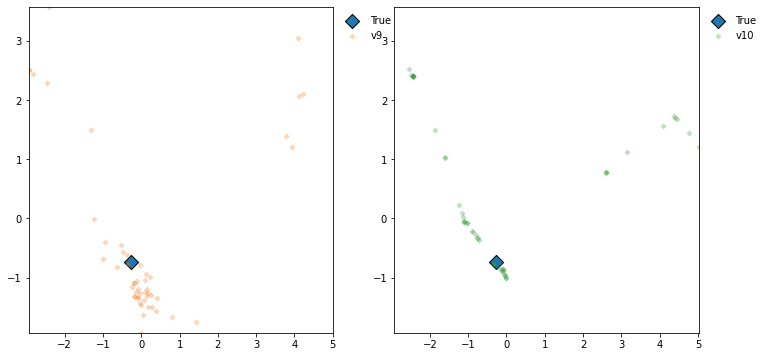


MMD diff: 1.6303367614746094
WSD diff: 0.1891550605124467

MMD cvae: 0.6053791046142578
WSD cvae: 0.0480235592000758


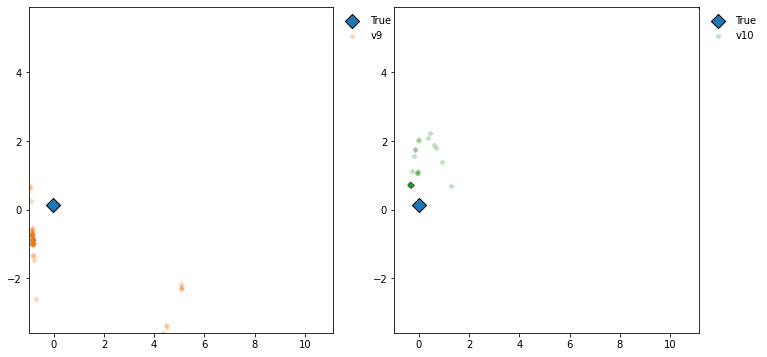


MMD diff: 1.098097801208496
WSD diff: 0.3615011539642992

MMD cvae: 0.6167640686035156
WSD cvae: 0.1615417462077468


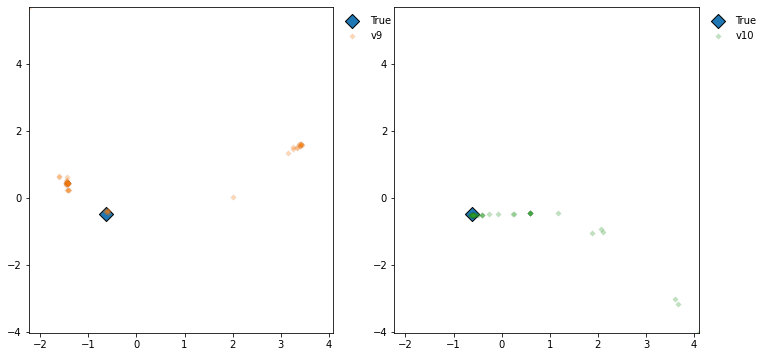


MMD diff: 6.17840051651001
WSD diff: 0.5454400587336427

MMD cvae: 0.9827508926391602
WSD cvae: 0.0050647187130489


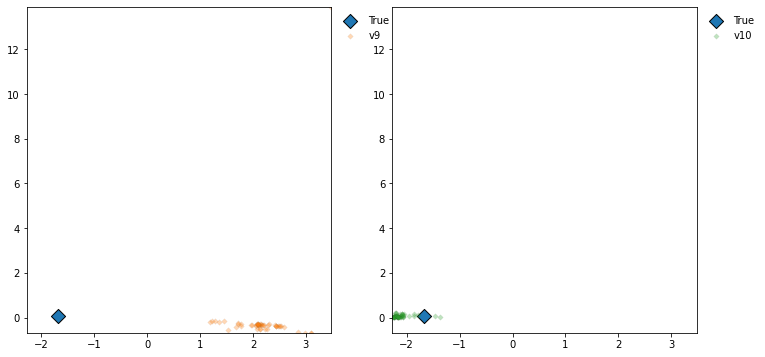


MMD diff: 2.488870620727539
WSD diff: 0.5301895516716254

MMD cvae: 3.217824935913086
WSD cvae: 0.1603048189015716


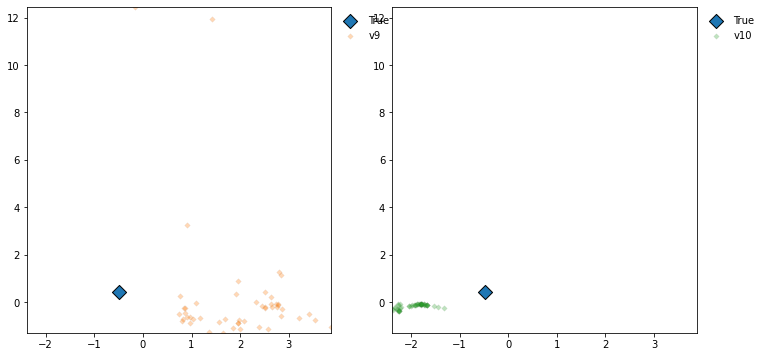


MMD diff: 2.14304256439209
WSD diff: 0.1803302282810241

MMD cvae: 3.704984664916992
WSD cvae: 0.1076529889367251


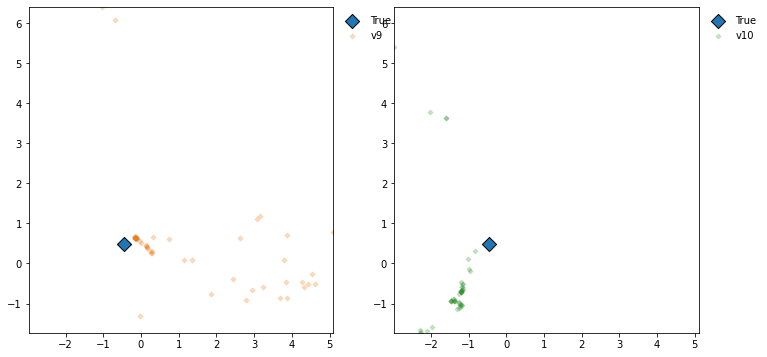


MMD diff: 0.1286211013793945
WSD diff: 0.0383945823222521

MMD cvae: 0.3001022338867187
WSD cvae: 0.0003991148768345


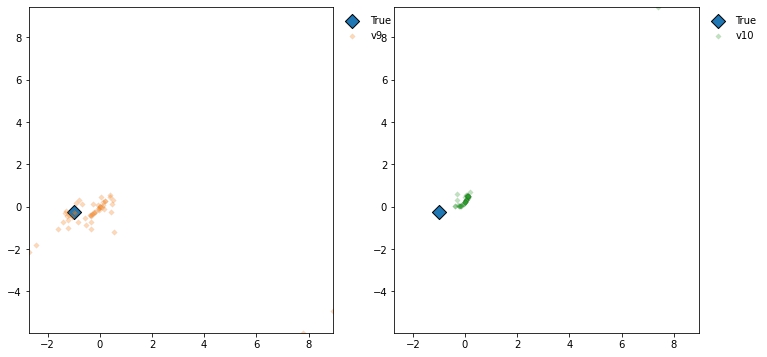


MMD diff: 2.459014892578125
WSD diff: 0.2039856041667352

MMD cvae: 1.1790037155151367
WSD cvae: 0.1272444086660513


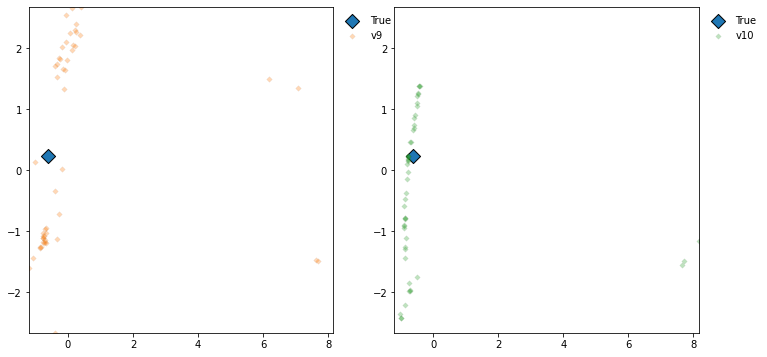


MMD diff: 1.8267574310302732
WSD diff: 0.0058629185612392

MMD cvae: 1.5663766860961914
WSD cvae: 0.1257821502321133


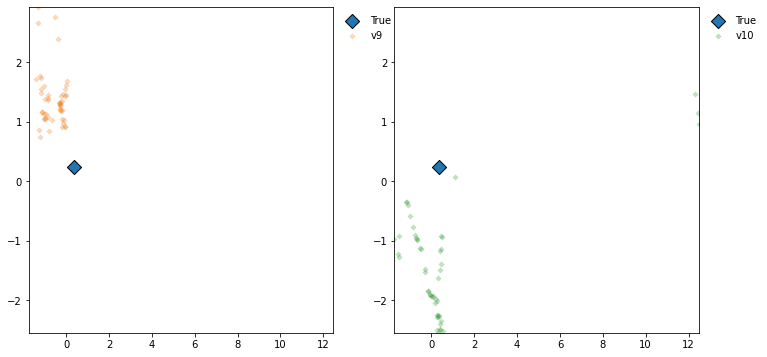


MMD diff: 2.7154359817504883
WSD diff: 0.066941320012944

MMD cvae: 0.2243661880493164
WSD cvae: 0.0002522356248401


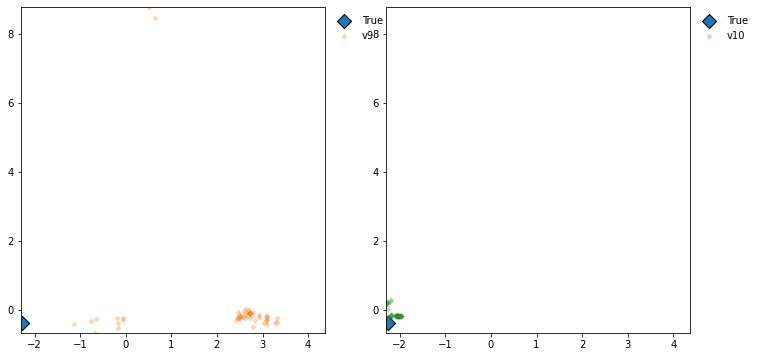


MMD diff: 1.6317710876464844
WSD diff: 0.0138136930813518

MMD cvae: 1.9194660186767576
WSD cvae: 0.0506936759251277


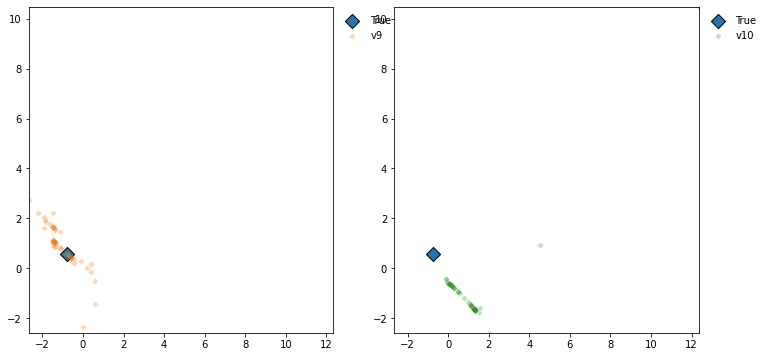


MMD diff: 6.496686458587647
WSD diff: 0.9472917174213408

MMD cvae: 6.638831615447998
WSD cvae: 0.9231434297191906


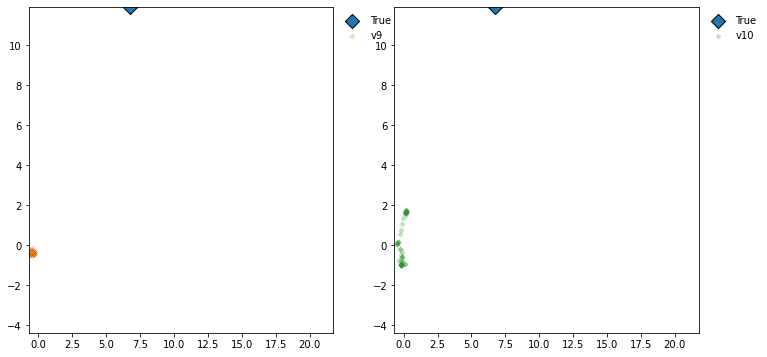


MMD diff: 0.6713724136352539
WSD diff: 0.025572097596539

MMD cvae: 4.094363212585449
WSD cvae: 0.3838342938155644


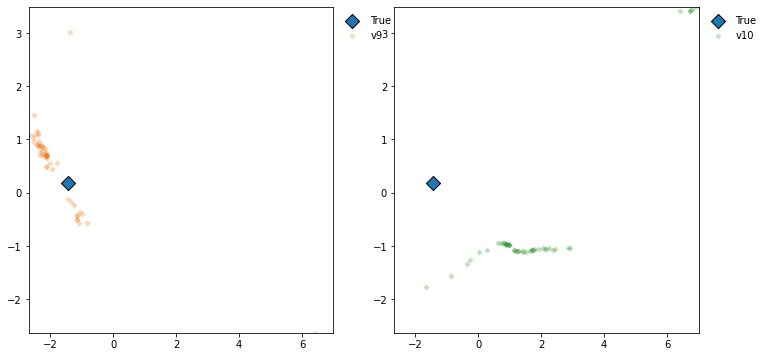


MMD diff: 1.337636947631836
WSD diff: 0.0175933651987535

MMD cvae: 3.461275100708008
WSD cvae: 0.3641173199528148


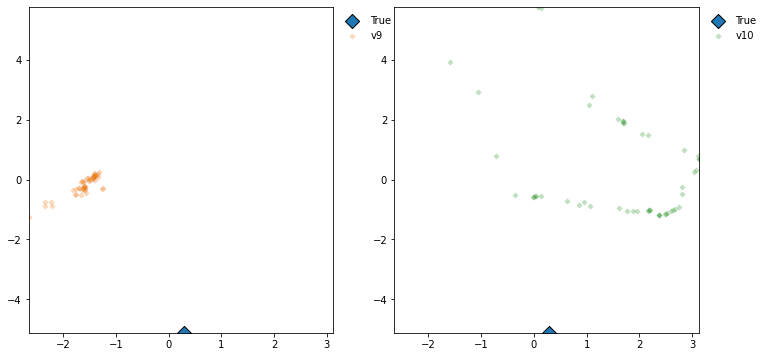


MMD diff: 5.321156024932861
WSD diff: 0.5560333131300101

MMD cvae: 5.363320827484131
WSD cvae: 0.5243319721862445


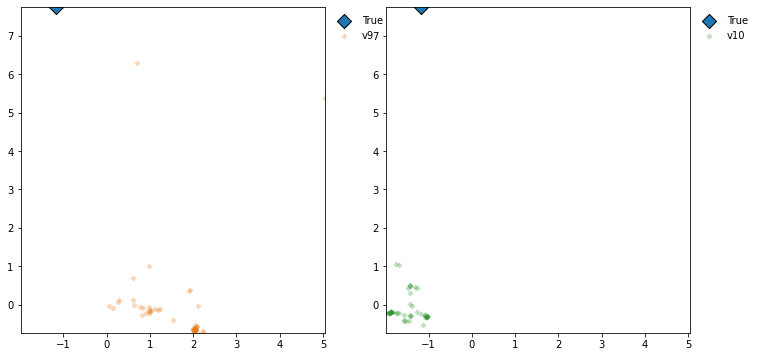


MMD diff: 5.683432102203369
WSD diff: 1.00644919833623

MMD cvae: 0.1748580932617187
WSD cvae: 0.0402375357050836


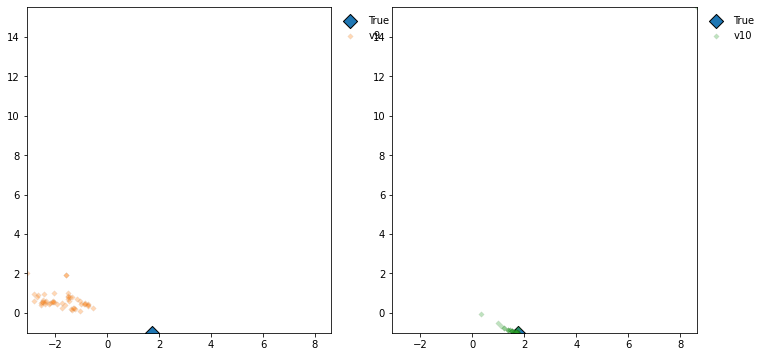


MMD diff: 3.1155967712402344
WSD diff: 0.8882718300082324

MMD cvae: 2.067270278930664
WSD cvae: 0.0135372935685285


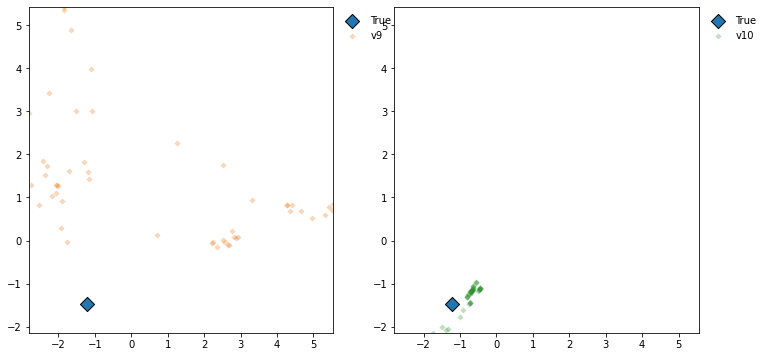


MMD diff: 5.030401706695557
WSD diff: 1.2604637431354626

MMD cvae: 4.327837944030762
WSD cvae: 0.397318759520017


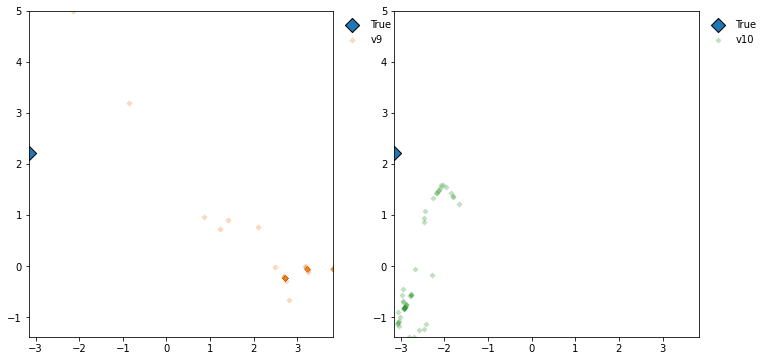


MMD diff: 1.7061796188354492
WSD diff: 0.1811467683049993

MMD cvae: 2.867852210998535
WSD cvae: 0.4699594115163471


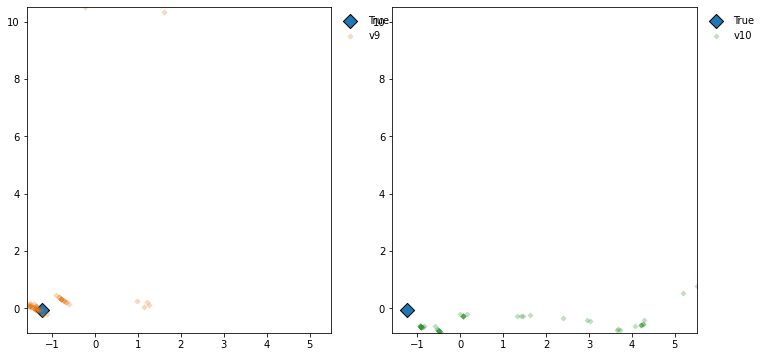


MMD diff: 4.469687461853027
WSD diff: 1.055293314505748

MMD cvae: 3.5360593795776367
WSD cvae: 0.7578478316428816


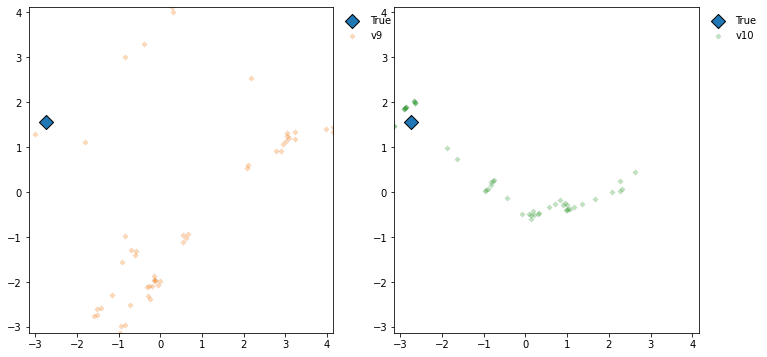


MMD diff: 0.5532302856445312
WSD diff: 0.2577495624037215

MMD cvae: 0.5688533782958984
WSD cvae: 0.0284510948183713


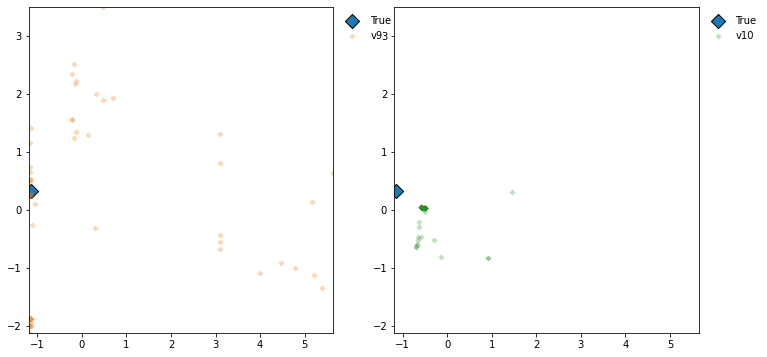


MMD diff: 5.094621658325195
WSD diff: 1.7258349206071402

MMD cvae: 6.459465026855469
WSD cvae: 1.9907761313066568


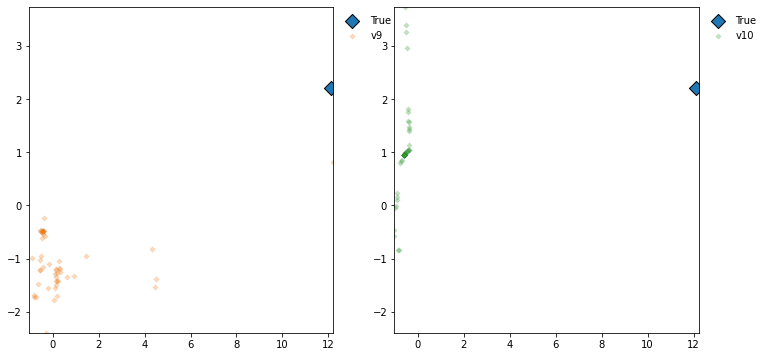


MMD diff: 2.510666847229004
WSD diff: 0.029629669139073

MMD cvae: 1.2351579666137695
WSD cvae: 0.0022884282893238


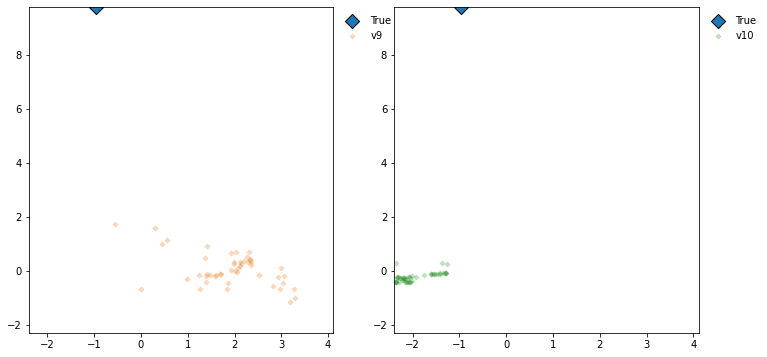


MMD diff: 0.7764139175415039
WSD diff: 0.0051216763146326

MMD cvae: 0.378819465637207
WSD cvae: 0.0004485397409335


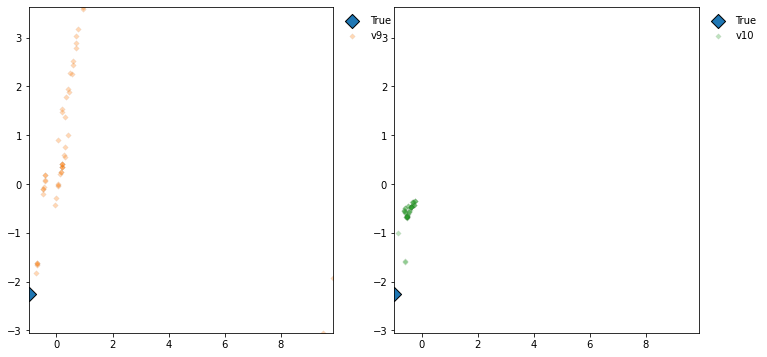


MMD diff: 0.398508071899414
WSD diff: 0.0005058699219372

MMD cvae: 0.6078805923461914
WSD cvae: 0.0015368109669768


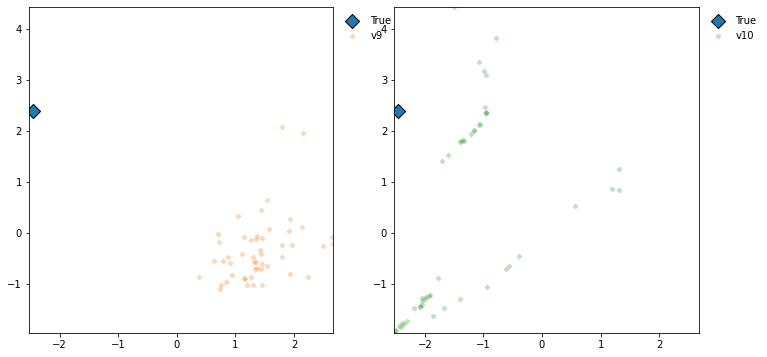


MMD diff: 1.8312864303588867
WSD diff: 0.1170045323194992

MMD cvae: 1.904672622680664
WSD cvae: 0.0830141085178365


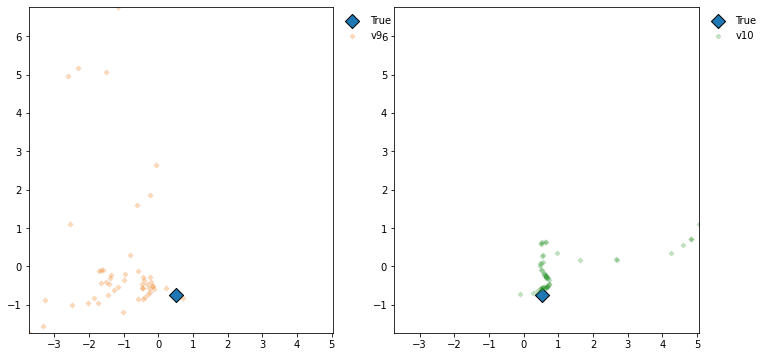


MMD diff: 3.800262451171875
WSD diff: 0.7985808272035991

MMD cvae: 1.556671142578125
WSD cvae: 0.0382995383480679


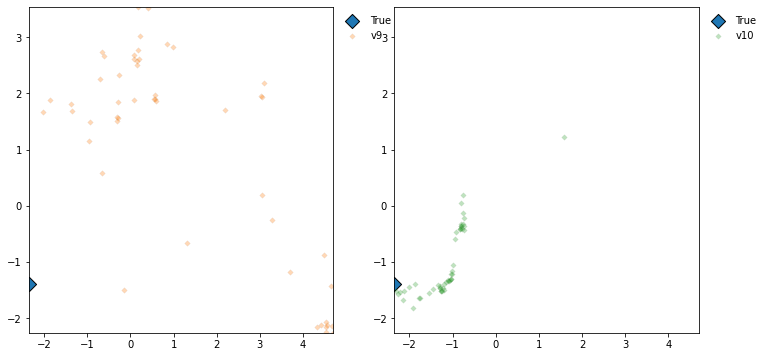


MMD diff: 5.208342552185059
WSD diff: 2.019307418746702

MMD cvae: 5.996287345886231
WSD cvae: 2.147184369021164


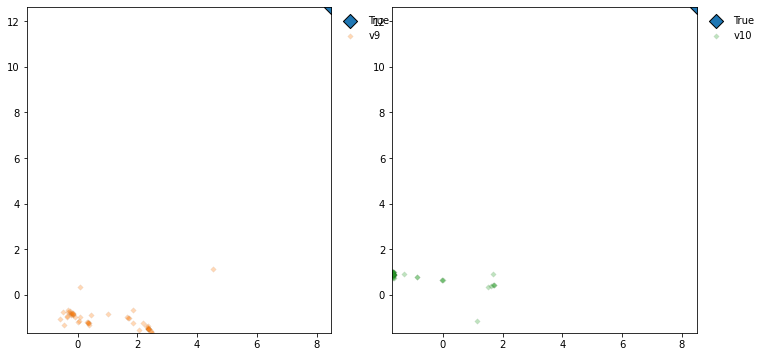


MMD diff: 2.768256187438965
WSD diff: 0.4816155871426332

MMD cvae: 3.921682357788086
WSD cvae: 0.7298169253330684


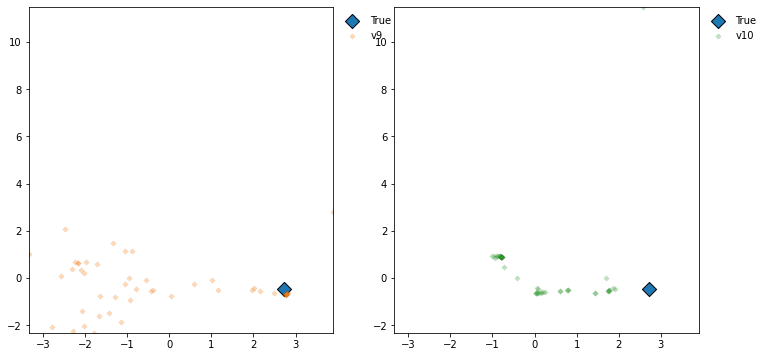


MMD diff: 0.0294971466064453
WSD diff: 3.093035337652112e-05

MMD cvae: 1.7760334014892578
WSD cvae: 0.0624680280082329


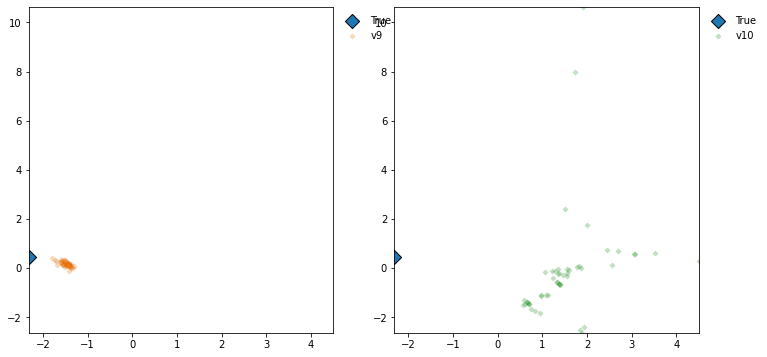

In [9]:
count = 0
for _, row in mmd_zeo_osda_df_cvae[::-1][['zeo', 'osda']].iterrows():
    zeo, osda = row['zeo'], row['osda']
    try:
        compare_side_by_side(syn_pred_diff, syn_pred_scaled_diff, syn_pred_cvae, syn_pred_scaled_cvae, syn_true_diff, syn_true_scaled_diff, dataset, mmd_zeo_agg_df_diff, wsd_zeo_agg_df_diff, mmd_zeo_osda_df_diff, wsd_zeo_osda_df_diff, mmd_zeo_agg_df_cvae, wsd_zeo_agg_df_cvae, mmd_zeo_osda_df_cvae, wsd_zeo_osda_df_cvae, zeo=zeo, osda=osda, plot=False, pca=True)
    except Exception as e:
        print(e)

    count += 1
    if count == 30:
        break